## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Cnidaria - Tim </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Chordata** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras import layers, models, optimizers

2025-04-10 19:42:28.619403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744310548.739189   54052 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744310548.772983   54052 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744310549.044932   54052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744310549.044964   54052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744310549.044966   54052 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)


Memory growth set for GPUs


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Chordata Phylum.

In [3]:
# Load the DataFrame from the CSV file
cnidaria_train = pd.read_csv("train_test_splits/cnidaria_train.csv")
cnidaria_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28219388,45276311,animalia,cnidaria,acroporidae,cnidaria_acroporidae/28219388_45276311_eol-ful...
1,29729570,45276321,animalia,cnidaria,acroporidae,cnidaria_acroporidae/29729570_45276321_eol-ful...
2,20332243,46545536,animalia,cnidaria,lobophylliidae,cnidaria_lobophylliidae/20332243_46545536_eol-...


In [4]:
# Load the DataFrame from the CSV file
cnidaria_test = pd.read_csv("train_test_splits/cnidaria_test.csv")
cnidaria_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,21699228,45276518,animalia,cnidaria,agariciidae,cnidaria_agariciidae/21699228_45276518_eol-ful...
1,2746810,45276959,animalia,cnidaria,siderastreidae,cnidaria_siderastreidae/2746810_45276959_eol-f...
2,29729172,45276583,animalia,cnidaria,fungiidae,cnidaria_fungiidae/29729172_45276583_eol-full-...


In [5]:
cnidaria_train.shape, cnidaria_test.shape

((647, 6), (162, 6))

In [6]:
cnidaria_train['family'].value_counts()

family
acroporidae         168
agariciidae          95
euphylliidae         72
faviidae             48
merulinidae          48
pocilloporidae       48
helioporidae         24
lobophylliidae       24
dendrophylliidae     24
siderastreidae       24
fungiidae            24
diploastraeidae      24
meandrinidae         24
Name: count, dtype: int64

In [7]:
cnidaria_train["family"].nunique()

13

# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

## 4.2 Advanced Preprocessing

In [8]:
#Define model shape
num_classes = cnidaria_train['family'].nunique() #number of classes = number of families
batch_size = 32
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)

### Augmentation

In [9]:
#Function to augment the images
def augment_image(image, label):

    #Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    #Apply geometric augmentations
    image = geometric_augmentation_layers(image, training=True) # Apply geometric augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


# Geometric augmentations
geometric_augmentation_layers = tf.keras.Sequential(
    [
        # Randomly flip horizontally
        tf.keras.layers.RandomFlip("horizontal"),

        # Randomly rotate
        tf.keras.layers.RandomRotation(factor=0.12),

        # Random zoom
        tf.keras.layers.RandomZoom(height_factor=(-0.35, 0.35), # Corresponds to [0.8, 1.2] of original height
                                   width_factor=(-0.35, 0.35)), # Corresponds to [0.8, 1.2] of original width

        # Random shift
        tf.keras.layers.RandomTranslation(height_factor=0.20,
                                          width_factor=0.20),

        # Contrast
        tf.keras.layers.RandomContrast(factor=0.25),

    ],
    name="geometric_augmentations",
)

# Define a conditional augmentation function that augments only if label is in minority
def conditional_augment(image, label):
    # Check if the label is in the minority set using tf.reduce_any
    condition = tf.reduce_any(tf.equal(label, minority_indices_tf))
    # Use tf.cond to branch: if True, apply augment_image; else, return the original image and label.
    return tf.cond(condition,
                   lambda: augment_image(image, label),
                   lambda: (image, label))

I0000 00:00:1744310554.950889   54052 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5329 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


### Pre-Process Pipeline

In [10]:
#Function to preprocess the images
def process_image(file_path, label):
    image = tf.io.read_file(file_path) # Read the image file
    image = tf.image.decode_jpeg(image, channels=3) # Decode the JPEG image
    image = tf.image.resize(image, image_size) # Resize the image to the target size
    
    #CHANGE THIS LINE DEPENDING ON WHICH PRE-TRAINED MODEL IS BEING USED
    
    #image = resnet_preprocess(image)  # Apply ResNet50 preprocessing
    image = mobilenet_preprocess(image)  # Apply MobileNetV2 preprocessing
    #image = efficientnet_preprocess(image)  # Apply EfficientNetB0 preprocessing
    #image = densenet_preprocess(image)  # Apply DenseNet121 preprocessing
    #image = inception_preprocess(image)  # Apply InceptionV3 preprocessing
    #image = tf.cast(image, tf.float32) / 255.0  # Apply ConvNeXt
    return image, label

### Tensorflow data set

In [11]:
import os
import tensorflow as tf

# --- Your existing steps for creating full paths and mapping labels ---
root_dir = "/root/DeepLearning2425/rare_species"

# Append full file paths to training and test DataFrames
cnidaria_train['full_path'] = cnidaria_train['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))
cnidaria_test['full_path'] = cnidaria_test['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))

file_paths_train = cnidaria_train['full_path'].tolist()
labels_train = cnidaria_train['family'].tolist()

file_paths_test = cnidaria_test['full_path'].tolist()
labels_test = cnidaria_test['family'].tolist()

# Map the labels to integers
label_names = sorted(set(labels_train))  # Get the unique labels
label_to_index = {name: i for i, name in enumerate(label_names)}  # Create a mapping from labels to integers
labels_train = [label_to_index[label] for label in labels_train]
labels_test = [label_to_index[label] for label in labels_test]

print(file_paths_train[:5])
print(labels_train[:5])
print(file_paths_test[:5])
print(labels_test[:5])

# --- Calculate which classes are "minority" based on a threshold ---
minority_threshold = 24
family_counts = cnidaria_train['family'].value_counts()
minority_families = family_counts[family_counts <= minority_threshold].index.tolist()
minority_indices = [label_to_index[fam] for fam in minority_families if fam in label_to_index]
print("Minority class indices:", minority_indices)
minority_indices_tf = tf.constant(minority_indices, dtype=tf.int32)

# --- Create the base dataset ---
data = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))
data = data.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=False, seed=42)

# --- Split train/val ---
train_size = int(0.8 * len(file_paths_train))  # 80% for training, 20% for validation
train = data.take(train_size)
val = data.skip(train_size)

# --- Oversampling Minority Classes ---
oversample_factor = 2  # Adjust this factor as desired

# Filter the training dataset into minority and majority subsets
minority_ds = train.filter(lambda fp, label: tf.reduce_any(tf.equal(label, minority_indices_tf)))
majority_ds = train.filter(lambda fp, label: tf.logical_not(tf.reduce_any(tf.equal(label, minority_indices_tf))))

# Repeat the minority dataset to oversample it
minority_ds = minority_ds.repeat(oversample_factor)

# Concatenate the majority and oversampled minority datasets
# Note: It's advisable to re-shuffle after concatenation
train = majority_ds.concatenate(minority_ds)
train = train.shuffle(buffer_size=train_size, reshuffle_each_iteration=True, seed=42)

# --- Training Preprocess Pipeline ---
train = train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
# Use your augmentation function here; if you want targeted augmentation instead, replace with conditional_augment.
train = train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train = train.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Validation Preprocess Pipeline ---
val = val.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
val = val.cache()
val = val.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Test Preprocess Pipeline ---
test = tf.data.Dataset.from_tensor_slices((file_paths_test, labels_test))
test = test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test = test.cache().batch(8).prefetch(tf.data.AUTOTUNE)

['/root/DeepLearning2425/rare_species/cnidaria_acroporidae/28219388_45276311_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_acroporidae/29729570_45276321_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_lobophylliidae/20332243_46545536_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_dendrophylliidae/22357017_45275716_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_acroporidae/28343272_45276323_eol-full-size-copy.jpg']
[0, 0, 8, 2, 0]
['/root/DeepLearning2425/rare_species/cnidaria_agariciidae/21699228_45276518_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_siderastreidae/2746810_45276959_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_fungiidae/29729172_45276583_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_faviidae/28170614_45276848_eol-full-size-copy.jpg', '/root/DeepLearning2425/rare_species/cnidaria_diploastraeidae/140750

# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

In [12]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

## 5.1 Baseline MobileNetV2

### Model Setup

In [14]:
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Load base model without top layer
base_model = MobileNetV2(
    input_shape=input_shape,  # Match your resized image shape
    include_top=False,         # Don't include the original classifier
    weights='imagenet'         # Use ImageNet-pretrained weights
)

# Freeze base model so we only train the new layers for now
base_model.trainable = False

model = models.Sequential([
    base_model,                                # Pre-trained feature extractor
    layers.GlobalAveragePooling2D(),           # Pool the spatial features
    layers.Dropout(0.3),                       # Dropout for regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularized Dense layer
    layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer with L2 regularizer
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Use a lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,629 (9.25 MB)

 Trainable params: 165,645 (647.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Model Training

In [15]:
y_train = np.array(labels_train)  # Replace labels_train with your training label list
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)

Computed class weights: {0: np.float64(0.29624542124542125), 1: np.float64(0.5238866396761134), 2: np.float64(2.073717948717949), 3: np.float64(2.073717948717949), 4: np.float64(0.6912393162393162), 5: np.float64(1.0368589743589745), 6: np.float64(2.073717948717949), 7: np.float64(2.073717948717949), 8: np.float64(2.073717948717949), 9: np.float64(2.073717948717949), 10: np.float64(1.0368589743589745), 11: np.float64(1.0368589743589745), 12: np.float64(2.073717948717949)}


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
        train,
        validation_data=val,
        epochs=40,           # Start small, increase if needed
        verbose=1
    )

#callbacks
checkpoint = ModelCheckpoint(
    "models/cnidaria_models/finetuned_best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

#save the model
model.save("models/cnidaria_models/finetuned_model.keras")

Epoch 1/40


I0000 00:00:1744310561.217929   54352 service.cc:152] XLA service 0x7f3048011fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744310561.217989   54352 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-10 19:42:41.472635: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744310562.165902   54352 cuda_dnn.cc:529] Loaded cuDNN version 90800


      5/Unknown 15s 31ms/step - accuracy: 0.1329 - loss: 3.2647  

I0000 00:00:1744310572.664064   54352 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     81/Unknown 28s 163ms/step - accuracy: 0.1298 - loss: 3.0716

2025-04-10 19:43:05.696651: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-10 19:43:05.697541: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-04-10 19:43:05.697553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18299305209117197365
2025-04-10 19:43:05.697587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17333329028757588754
/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` functio

81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 301ms/step - accuracy: 0.1301 - loss: 3.0695 - val_accuracy: 0.2846 - val_loss: 2.4739
Epoch 2/40
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2312 - loss: 2.6454

2025-04-10 19:43:18.879480: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2326 - loss: 2.6410 - val_accuracy: 0.2769 - val_loss: 2.3742
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2825 - loss: 2.4781 - val_accuracy: 0.3538 - val_loss: 2.2861
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3531 - loss: 2.2718 - val_accuracy: 0.3692 - val_loss: 2.2342
Epoch 5/40


2025-04-10 19:43:23.361895: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3536 - loss: 2.1990 - val_accuracy: 0.3692 - val_loss: 2.1952
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3747 - loss: 2.1053 - val_accuracy: 0.3923 - val_loss: 2.1644
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4888 - loss: 1.9768 - val_accuracy: 0.4154 - val_loss: 2.1384
Epoch 8/40
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4339 - loss: 1.9829

2025-04-10 19:43:32.337938: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4356 - loss: 1.9782 - val_accuracy: 0.4231 - val_loss: 2.1088
Epoch 9/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4834 - loss: 1.8633 - val_accuracy: 0.4385 - val_loss: 2.1011
Epoch 10/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4844 - loss: 1.8563 - val_accuracy: 0.4231 - val_loss: 2.0866
Epoch 11/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5305 - loss: 1.7661 - val_accuracy: 0.4385 - val_loss: 2.0635
Epoch 12/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5071 - loss: 1.7609 - val_accuracy: 0.4308 - val_loss: 2.0579
Epoch 13/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5245 - loss: 1.7642 - val_accuracy: 0.4385 - val_loss: 2.0206
Epoch 14/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5437 - loss: 1.6467 - val_accuracy: 0.4462 - val_loss: 2.0255
Epoch 15/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5165 - loss: 1.6899 - val_accuracy: 0.4538 - val_lo

2025-04-10 19:43:51.287133: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 17/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6037 - loss: 1.5342 - val_accuracy: 0.4615 - val_loss: 2.0142
Epoch 18/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5716 - loss: 1.5471 - val_accuracy: 0.4308 - val_loss: 2.0121
Epoch 19/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5641 - loss: 1.5873 - val_accuracy: 0.4538 - val_loss: 1.9959
Epoch 20/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5697 - loss: 1.5596 - val_accuracy: 0.4385 - val_loss: 2.0054
Epoch 21/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5936 - loss: 1.4176 - val_accuracy: 0.4462 - val_loss: 1.9998
Epoch 22/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6359 - loss: 1.4133 - val_accuracy: 0.4308 - val_loss: 2.0073
Epoch 23/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6125 - loss: 1.4309 - val_accuracy: 0.4385 - val_loss: 1.9752
Epoch 24/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6730 - loss: 1.3699 - val_accuracy: 0.

2025-04-10 19:44:28.240247: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6571 - loss: 1.3019 - val_accuracy: 0.4846 - val_loss: 1.9766
Epoch 34/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6570 - loss: 1.2891 - val_accuracy: 0.4846 - val_loss: 2.0084
Epoch 35/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6525 - loss: 1.2264 - val_accuracy: 0.5000 - val_loss: 1.9849
Epoch 36/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7027 - loss: 1.2193 - val_accuracy: 0.4692 - val_loss: 2.0081
Epoch 37/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6759 - loss: 1.2170 - val_accuracy: 0.4923 - val_loss: 1.9808
Epoch 38/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6685 - loss: 1.2030 - val_accuracy: 0.4692 - val_loss: 2.0203
Epoch 39/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7236 - loss: 1.1379 - val_accuracy: 0.4769 - val_loss: 1.9736
Epoch 40/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6931 - loss: 1.1843 - val_accuracy: 0.4846 - val_l

In [17]:
#get the best accuracy score
best_accuracy = max(history.history['val_accuracy'])
print("Best validation accuracy:", best_accuracy)

Best validation accuracy: 0.5076923370361328


### Result Visualizations

In [18]:
#This function is used in notebook 2, notebook 3 and notebook 4
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


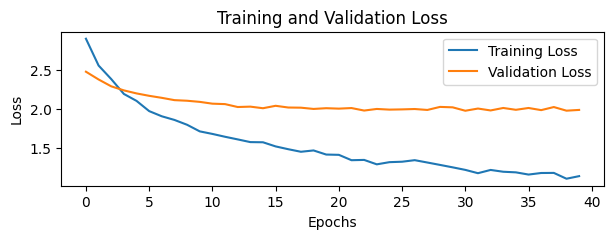

In [19]:
plot_loss(history)

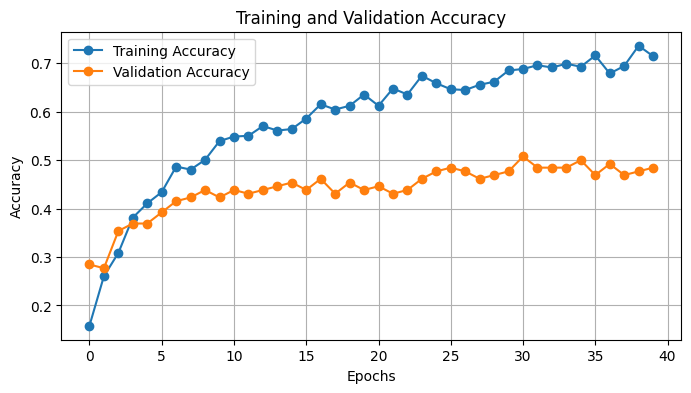

In [20]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history)


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step


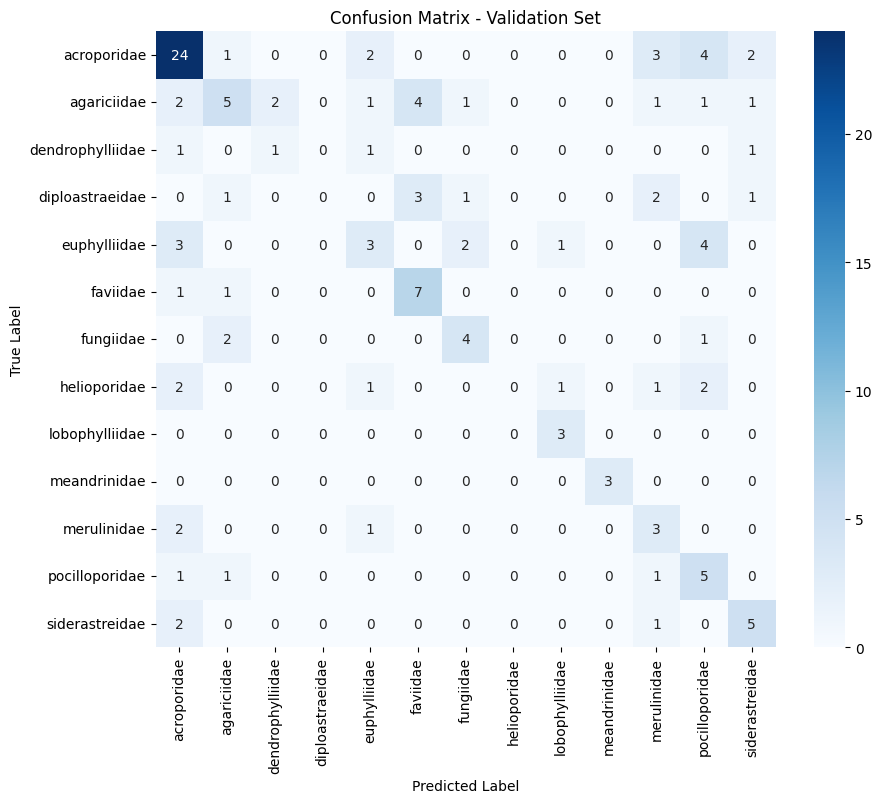

                  precision    recall  f1-score   support

     acroporidae       0.63      0.67      0.65        36
     agariciidae       0.45      0.28      0.34        18
dendrophylliidae       0.33      0.25      0.29         4
 diploastraeidae       0.00      0.00      0.00         8
    euphylliidae       0.33      0.23      0.27        13
        faviidae       0.50      0.78      0.61         9
       fungiidae       0.50      0.57      0.53         7
    helioporidae       0.00      0.00      0.00         7
  lobophylliidae       0.60      1.00      0.75         3
    meandrinidae       1.00      1.00      1.00         3
     merulinidae       0.25      0.50      0.33         6
  pocilloporidae       0.29      0.62      0.40         8
  siderastreidae       0.50      0.62      0.56         8

        accuracy                           0.48       130
       macro avg       0.42      0.50      0.44       130
    weighted avg       0.44      0.48      0.45       130



/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the validation set
# This returns probabilities, so we use argmax to obtain predicted class indices.
y_val_pred_probs = model.predict(val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Extract the true labels from the validation dataset
y_val_true = []
for images, labels in val:
    # Convert labels from a tensor to a NumPy array and extend our list.
    y_val_true.extend(labels.numpy())
y_val_true = np.array(y_val_true)

# Compute the confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Optional: if you have the label names (sorted list of unique labels), use them for tick labels
# For example, if defined earlier:
# label_names = sorted(set(labels_train))
# If not, you can omit xticklabels and yticklabels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Print a detailed classification report
print(classification_report(y_val_true, y_val_pred, target_names=label_names))
